In [0]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

In [0]:
train = pd.read_excel('/content/Data_Train.xlsx')
test = pd.read_excel('/content/Data_Test.xlsx')

In [34]:
train.shape, test.shape

((6019, 13), (1234, 12))

In [35]:
train.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 13 columns):
Name                 6019 non-null object
Location             6019 non-null object
Year                 6019 non-null int64
Kilometers_Driven    6019 non-null int64
Fuel_Type            6019 non-null object
Transmission         6019 non-null object
Owner_Type           6019 non-null object
Mileage              6017 non-null object
Engine               5983 non-null object
Power                5983 non-null object
Seats                5977 non-null float64
New_Price            824 non-null object
Price                6019 non-null float64
dtypes: float64(2), int64(2), object(9)
memory usage: 611.4+ KB


In [37]:


train.isnull().sum()



Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [0]:
train = train[train['Kilometers_Driven'] < 700000]
train = train[train['Kilometers_Driven'] > 999]


In [0]:
train = train[train['Fuel_Type'] != 'Electric']

In [0]:
train = train[train['Name'] != 'Ambassador Classic Nova Diesel']
train = train[train['Name'] != 'Lamborghini Gallardo Coupe']
train = train[train['Name'] != 'Force One LX 4x4']
train = train[train['Name'] != 'Force One LX ABS 7 Seating']
train = train[train['Name'] != 'Smart Fortwo CDI AT']

In [0]:
df = train.append(test, ignore_index=True, sort=False)

In [42]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [0]:
df['Mileage'] = df['Mileage'].apply(lambda x : str(x).split(' ')[0]).astype(float)

In [0]:
df['Engine'] = df['Engine'].apply(lambda x : str(x).split(" ")[0]).astype(float)

In [0]:
df['Power'] = df['Power'].replace('null bhp','0 bhp').apply(lambda x : str(x).split(' ')[0]).astype(float)

In [0]:
df['Seats'] = df['Seats'].fillna(5)

In [0]:
df['New_Price'] = df['New_Price'].fillna('-1 Lakhs').apply(lambda x: x.split(' ')[0]) 
df['New_Price'] = df['New_Price'].astype(float).replace(-1, np.nan)

In [0]:
df['Year'] = df['Year'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Fuel_Type'] = df['Fuel_Type'].astype('category')
df['Transmission'] = df['Transmission'].astype('category')
df['Owner_Type'] = df['Owner_Type'].astype('category')


In [0]:
df['Car_Brand1'] = df['Name'].apply(lambda x: ' '.join(x.split(' ')[:2]))

df['Engine'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.median()))['Engine']
df['Power'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.median()))['Power']
df['New_Price'] = df.groupby(['Car_Brand1']).transform(lambda x: x.fillna(x.mean()))['New_Price']

In [0]:
df['Car_Brand2'] = df['Name'].apply(lambda x: x.split(' ')[0])

df['New_Price'] = df.groupby(['Car_Brand2']).transform(lambda x: x.fillna(x.mean()))['New_Price']

In [0]:
def aggregate_functions(df):        
    
    agg_func = {
        'Location' : ['count'],
        'Mileage' : ['mean'],
        'Power' : ['mean'],
        'Engine' : ['mean'] }
    
    agg_df = df.groupby(['Car_Brand1']).agg(agg_func)
    agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
    agg_df.reset_index(inplace=True)
    
    agg_df = pd.merge(df, agg_df, on='Car_Brand1', how='left')
    
    return agg_df

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf1 = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 1), max_df=1.0, min_df=2, binary=True)
df_name = tf1.fit_transform(df['Name'])
df_name = pd.DataFrame(data=df_name.toarray(), columns=tf1.get_feature_names())

df = pd.concat([df, df_name], axis=1)


In [0]:
df.drop(['Name','Car_Brand1','Car_Brand2'], axis=1, inplace=True)

In [54]:
train_df = df[df['Price'].isnull()!=True]
test_df = df[df['Price'].isnull()==True]
test_df.drop('Price', axis=1, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [55]:
train_df['Price'] = np.log1p(train_df['Price'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
X = train_df.drop(labels=['Price'], axis=1)
y = train_df['Price'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=1)

In [57]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((4504, 664), (4504,), (1502, 664), (1502,))

In [0]:
from math import sqrt 
from sklearn.metrics import mean_squared_log_error


In [59]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.05, 
         'num_iterations': 1000,
         'num_leaves': 30,
         'max_depth': -1,
         'min_data_in_leaf': 4,
         'bagging_fraction': 0.78,
         'bagging_freq': 1,
         'feature_fraction': 0.65,
         }

lgbm = lgb.train(params=param,
                 verbose_eval=100,
                 early_stopping_rounds=50,
                 train_set=train_data,
                 valid_sets=[test_data])

y_pred_lgbm = lgbm.predict(X_cv)
print('RMSLE:', sqrt(mean_squared_log_error(np.expm1(y_cv), np.expm1(y_pred_lgbm))))

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 50 rounds.
[100]	valid_0's rmse: 0.164864
[200]	valid_0's rmse: 0.152984
[300]	valid_0's rmse: 0.150439
[400]	valid_0's rmse: 0.149424
[500]	valid_0's rmse: 0.14907
[600]	valid_0's rmse: 0.148659
[700]	valid_0's rmse: 0.148361
Early stopping, best iteration is:
[692]	valid_0's rmse: 0.148262
RMSLE: 0.14826216796408692


In [0]:
Xtest = test_df

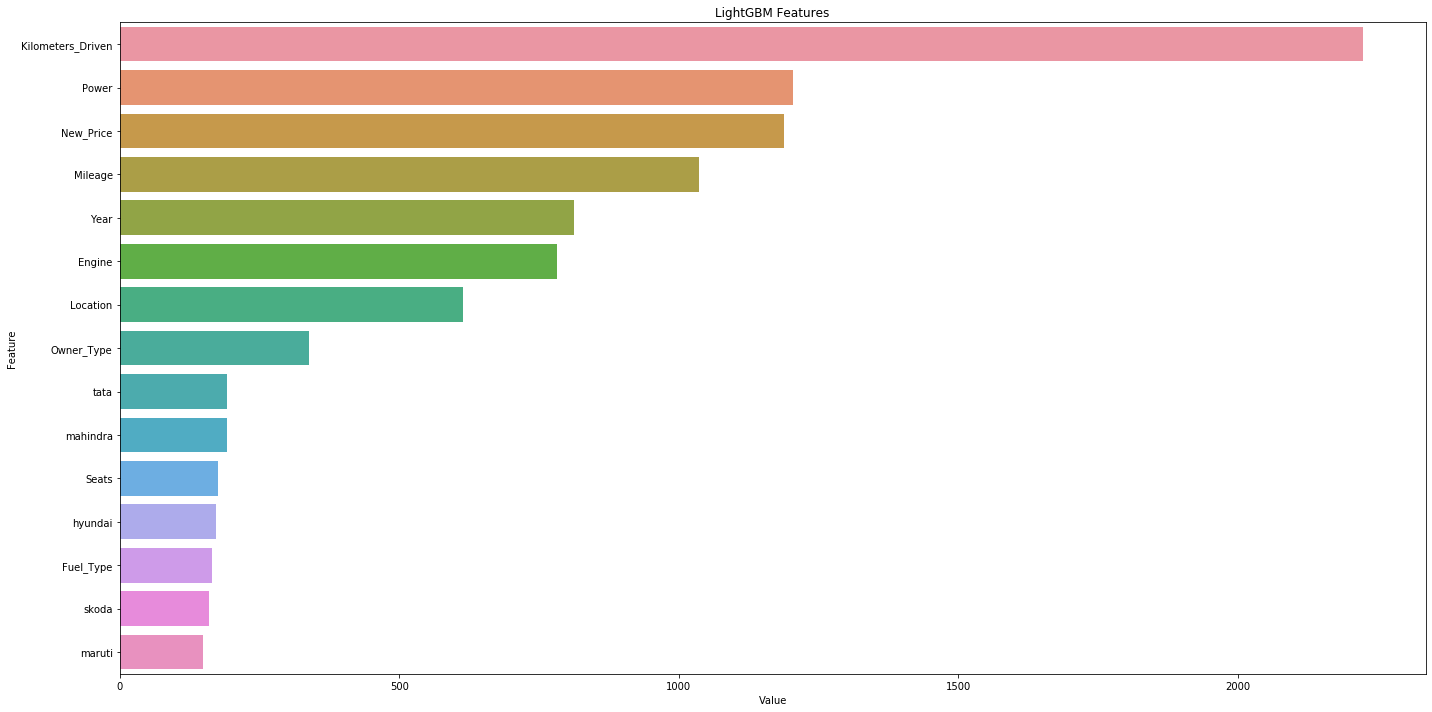

In [61]:
feature_imp = pd.DataFrame(sorted(zip(lgbm.feature_importance(), X.columns), reverse=True)[:15], 
                           columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [62]:
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor

errlgb = []
y_pred_totlgb = []

fold = KFold(n_splits=15, shuffle=True, random_state=42)

for train_index, test_index in fold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    param = {'objective': 'regression',
         'boosting': 'gbdt',  
         'metric': 'l2_root',
         'learning_rate': 0.05, 
         'num_iterations': 1000,
         'num_leaves': 30,
         'max_depth': -1,
         'min_data_in_leaf': 4,
         'bagging_fraction': 0.78,
         'bagging_freq': 1,
         'feature_fraction': 0.65
         }

    lgbm = LGBMRegressor(**param)
    lgbm.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0, early_stopping_rounds=50)

    y_pred_lgbm = lgbm.predict(X_test)
    print("RMSLE LGBM: ", sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))

    errlgb.append(sqrt(mean_squared_log_error(np.expm1(y_test), np.expm1(y_pred_lgbm))))
    p = lgbm.predict(Xtest)
    
    y_pred_totlgb.append(p)


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14067459927625467


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.13176770660743947


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.1280231967975974


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.12546768285374785


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.12417433985537697


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14837591414453047


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.21107678327170212


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.10962022985755512


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.1426317186684687


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.13224584777482484


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.10770346532345494


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.11958701067330814


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.12153056398695693


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.12767121326463463


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


RMSLE LGBM:  0.14927055013514173


In [63]:
np.mean(errlgb)

0.1346547214993996

In [0]:
lgbm_final = np.expm1(np.mean(y_pred_totlgb,0))


In [0]:
df_sub = pd.DataFrame(data=lgbm_final, columns=['Price'])

In [0]:
df_sub.to_excel('car.xlsx', index=False)